In [1]:
import networkx as nx
import random
import numpy as np

import scipy as sc

import matplotlib.pyplot as plt

# Dataset

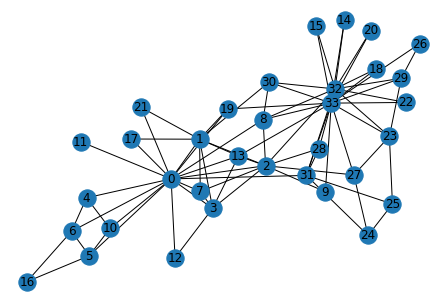

In [2]:
G = nx.karate_club_graph()
nx.draw(G, with_labels=True)

[(15, 32), (0, 1), (13, 33), (0, 2), (0, 10), (8, 32), (2, 8), (3, 12), (1, 30), (14, 33), (23, 29), (24, 25), (2, 9), (3, 13), (3, 7), (0, 13), (30, 32), (0, 12), (29, 32), (2, 28), (0, 8), (22, 33), (2, 27)]


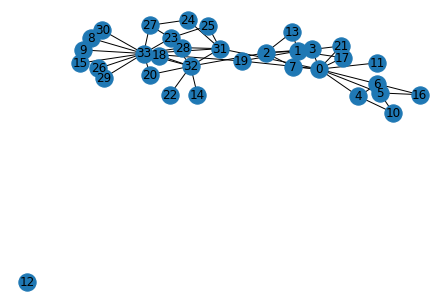

In [3]:
# train on 80% edges, test on 20% removed edges (see if can predict existence of links)

# Remove 20% of the edges
proportion_edges = 0.3
# this is our test set
edge_subset = random.sample(G.edges(), int(proportion_edges * G.number_of_edges()))

# Create a copy of the graph and remove the edges
G_train = G.copy()
G_train.remove_edges_from(edge_subset)

print(edge_subset)
nx.draw(G_train, with_labels=True)


In [4]:
# test graph

G_test = nx.Graph()
G_test.add_edges_from(edge_subset)

# G_test.neighbors(5)

# Link Prediction

In [5]:
def MAP(G_test, G_pred):
    nodes = G_test.nodes()

    # calculate avePrecision for each node and its neighbors
    avePs = []
    for node in nodes:
        # get groundtruth neighbors
        gt = set(G_test[node])

        # get ranked predicted values
        rankedPredWeights = sorted(G_pred[node].items(), key=lambda x: -x[1]['weight'])
        thres = 0
        rankedPred = filter(lambda x: x[1]['weight'] > thres, rankedPredWeights)
        pred = [x[0] for x in rankedPred]

        # calculate rel
        rel = np.array([x in gt for x in pred])

        # calculate P
        predLength = len(pred)
        P = np.array([
            sum(rel[:i+1])/len(rel[:i+1]) for i in range(predLength)
            ])
        aveP = (rel @ P)/len(gt)

        avePs.append(aveP)

    MAPvalue = sum(avePs) / len(avePs)
    
    return MAPvalue

In [6]:
# Make prediction using Jaccard Coefficient
pred = list(nx.jaccard_coefficient(G_train))
# create graph
G_pred = nx.Graph()
G_pred.add_weighted_edges_from(pred)

# evaluate MAP
MAP(G_test, G_pred)

0.2947679845407118

In [7]:
# Make prediction using Adamic Adar
pred = list(nx.adamic_adar_index(G_train))
# create graph
G_pred = nx.Graph()
G_pred.add_weighted_edges_from(pred)

# evaluate MAP
MAP(G_test, G_pred)

0.2575377274240911

In [8]:
pred = list(nx.preferential_attachment(G_train))
# create graph
G_pred = nx.Graph()
G_pred.add_weighted_edges_from(pred)

# evaluate MAP
MAP(G_test, G_pred)

0.35785530851213254

In [9]:
def spectralTransform(alpha):
    # link prediction using spectral transformation
    A = nx.adjacency_matrix(G)
    A = A.toarray()

    # adjacency matrix
    A_train = nx.adjacency_matrix(G_train)
    A_train = A_train.toarray()

    # eigenvalue decomposition
    V_train, U_train = np.linalg.eig(A_train)

    # DEBUG
    # # U.T * Atest * U
    # target_V = U_train.T @ A @ U_train
    # # take only the diagonals
    # target_V = np.diag(target_V)

    # # assume our function is exponential V_train with alpha = 0.6
    # plt.figure(figsize=(5, 3))
    # plt.scatter(V_train, target_V, c='b')
    # plt.scatter(V_train, np.exp(V_train*alpha), c='r')
    # plt.show()

    # perform Function on A_train
    A_test_pred = sc.linalg.expm(A_train * alpha)

    pred = [(i, j, A_test_pred[i, j]) for i in range(A_test_pred.shape[0]) for j in range(A_test_pred.shape[1])]

    return pred


pred = spectralTransform(alpha=1.8)

# create graph
G_pred = nx.Graph()
G_pred.add_weighted_edges_from(pred)

# evaluate MAP
MAP(G_test, G_pred)

0.32776712978284683

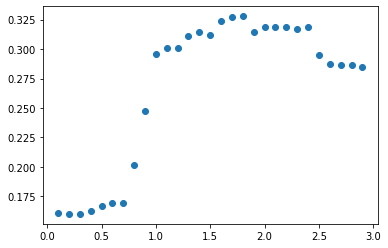

In [10]:
# hyperparameter optimisation: try several alpha

_maps = []
for alpha in range(1, 30, 1):
    alpha /= 10

    pred = spectralTransform(alpha)

    # create graph
    G_pred = nx.Graph()
    G_pred.add_weighted_edges_from(pred)

    # evaluate MAP
    _map = MAP(G_test, G_pred)

    _maps.append([alpha, _map])

_maps = np.array(_maps)
plt.scatter(_maps[:, 0], _maps[:, 1])
plt.show()

# Debug

In [11]:
# debug
gts = {
    1: {1, 3, 5, 8},
    2: {3, 5, 7, 9, 11}
}
preds = {
    1: [4, 3, 5, 6, 7],
    2: [3, 10, 9, 2]
}

# calculate avePrecision for each node and its neighbors
avePs = []
for node in [1, 2]:
    # get groundtruth neighbors
    gt = gts[node]

    # get ranked predicted values
    pred = preds[node]

    # calculate rel
    rel = np.array([x in gt for x in pred])

    # calculate P
    predLength = len(pred)
    P = np.array([sum(rel[:i+1])/len(rel[:i+1]) for i in range(predLength)])
    aveP = (rel @ P)/len(gt)

    avePs.append(aveP)

MAPvalue = sum(avePs) / len(avePs)
assert MAPvalue == 15/48